# Brain Tumor Detection by using MRI Images🧠🩺

# PROJECT IS UNDER CONSTRUCTION

In [1]:
import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

import tensorflow as tf
from tensorflow.keras.layers import Conv2D,BatchNormalization, MaxPooling2D,Dropout,Flatten,Dense, Activation
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

sns.set_style('darkgrid')
%matplotlib inline
init_notebook_mode(connected=True)
warnings.filterwarnings('ignore')

RANDOM_SEED = 101


## Dataset

- `NO` - no tumor, encoded as `0`
- `YES` - tumor, encoded as `1`

 Right now all images are in one folder with yes and no subfolders. I will split the data into train, val and test folders which makes its easier to work for me. The new folder heirarchy will look as follows:

In [2]:
IMG_PATH = 'brain_tumor_dataset/'

# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n<5:
                shutil.copy(img, 'NORMAL/TEST/' + CLASS.upper() + '/' + FILE_NAME)
            elif n<0.8*IMG_NUM:
                shutil.copy(img, 'NORMAL/TRAIN/' + CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'NORMAL/VAL/' + CLASS.upper() + '/' + FILE_NAME)

## Data import and Preprocessing

In [3]:
def load_data(dir_path, img_size=(100,100)):
    X = []
    y = []
    i=0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

## Data Loading

In [4]:
TRAIN_DIR = 'NORMAL/TRAIN/'
TEST_DIR = 'NORMAL/TEST/'
VAL_DIR = 'NORMAL/VAL/'
IMG_SIZE = (180,180)

X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _  = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.85it/s]


193 images loaded from NORMAL/TRAIN/ directory.


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 49.77it/s]


10 images loaded from NORMAL/TEST/ directory.


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.97it/s]

50 images loaded from NORMAL/VAL/ directory.


In [5]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = accuracy_score(y_true, y_pred)
    
    return score

## Distribution of classes among sets:

In [6]:
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name==0))
    y[1].append(np.sum(set_name==1))
trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7)

data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title':'Set'},
    yaxis={'title':'Count'}
)
fig = go.Figure(data,layout)
iplot(fig)

## Plot samples

In [7]:
def plot_samples(X,y,labels_dict, n=50):
    """
        Create a gridplot for desired number of images (n) from specified set
    """ 
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y==index)][:n]
        j = 10
        i = int(n/j)
        
        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0].astype("uint8"))
            
            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

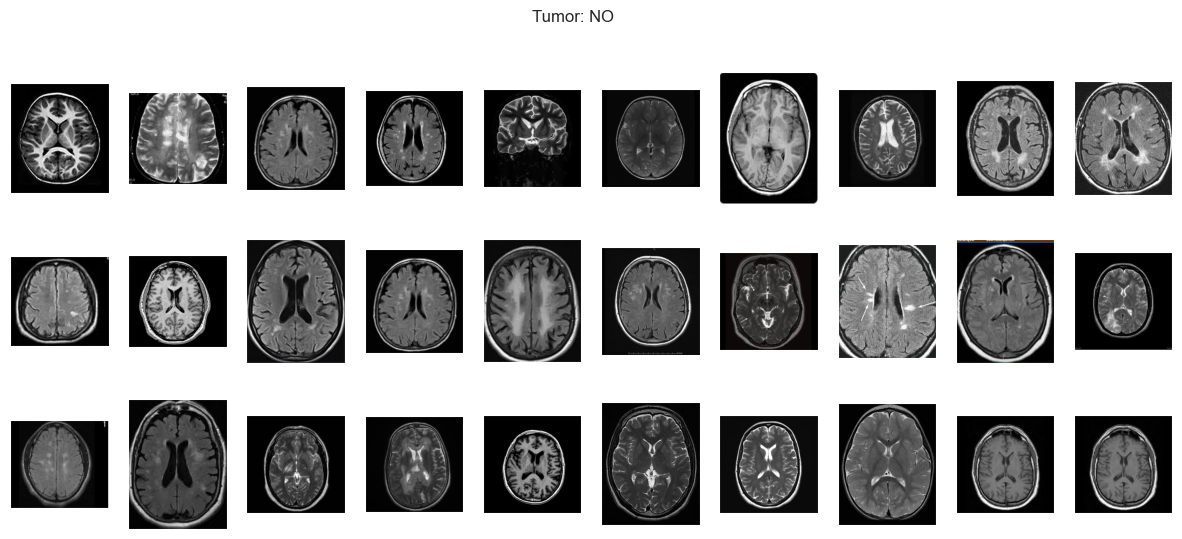

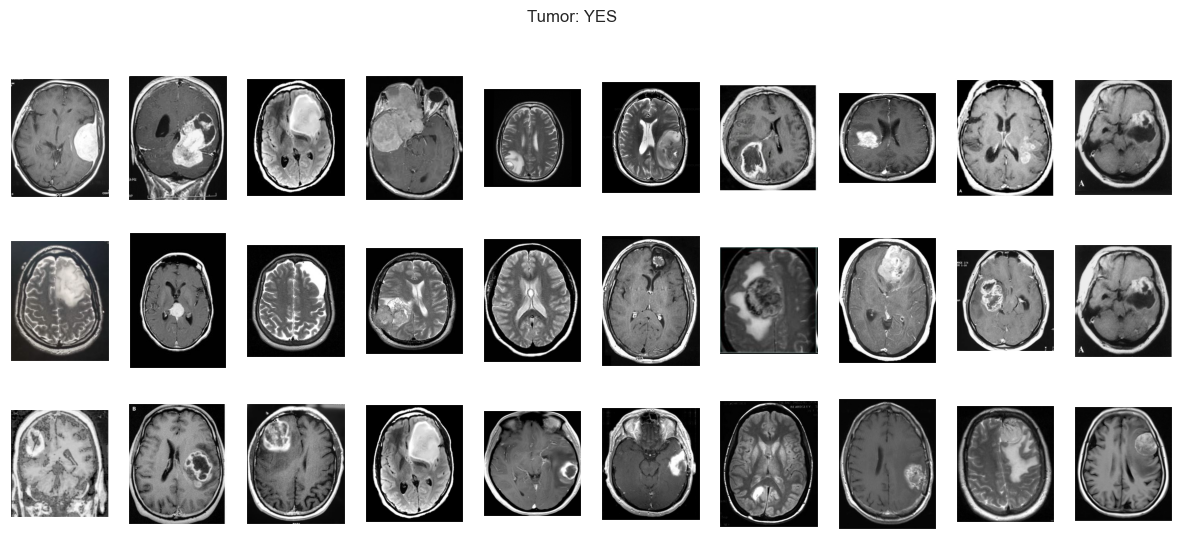

In [8]:
plot_samples(X_train, y_train, labels, 30)

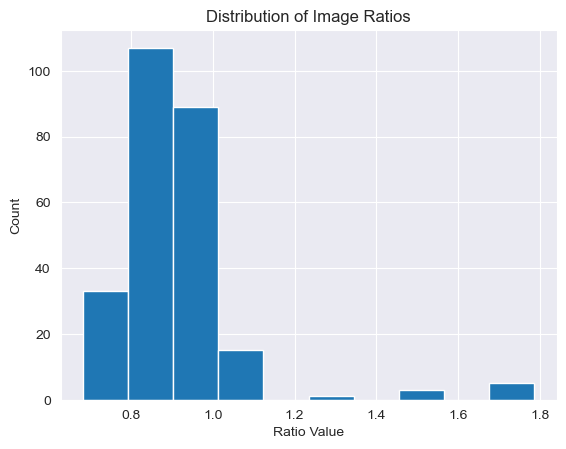

In [9]:
RATIO_LIST = []
for set in (X_train, X_test, X_val):
    for img in set:
        RATIO_LIST.append(img.shape[1]/img.shape[0])
        
plt.hist(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()

The first step of "normalization" would be to crop the brain out of the images.

`Erosion is an operation that erodes away the boundaries of foreground objects. It is performed by applying a structuring element (kernel) to the image and replacing the central pixel of the kernel with the minimum value of the pixels under the kernel. This reduces the size of the foreground objects and eliminates small white pixels (noise) from the image.

Dilation is the opposite of erosion. It expands the boundaries of the foreground objects by replacing the central pixel of the kernel with the maximum value of the pixels under the kernel. This increases the size of the foreground objects and fills small holes in the objects.`

In [10]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

In [11]:
img = cv2.imread('brain_tumor_dataset/yes/Y108.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
img = cv2.imread('brain_tumor_dataset/yes/Y108.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

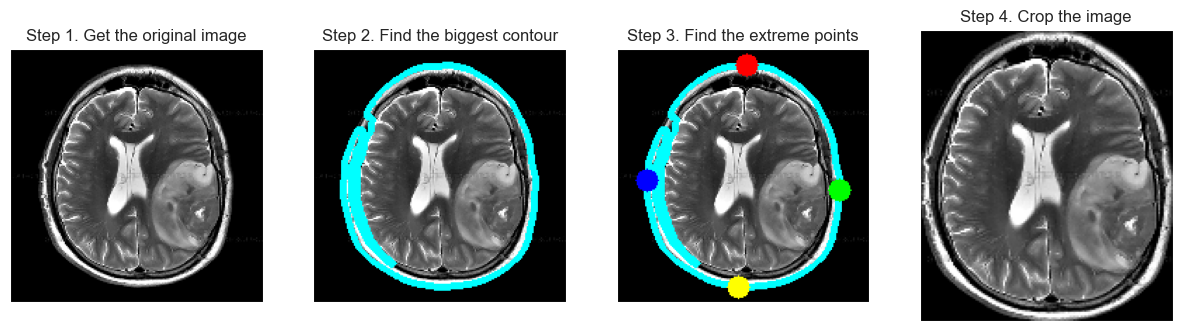

In [12]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')

plt.show();

In [13]:
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

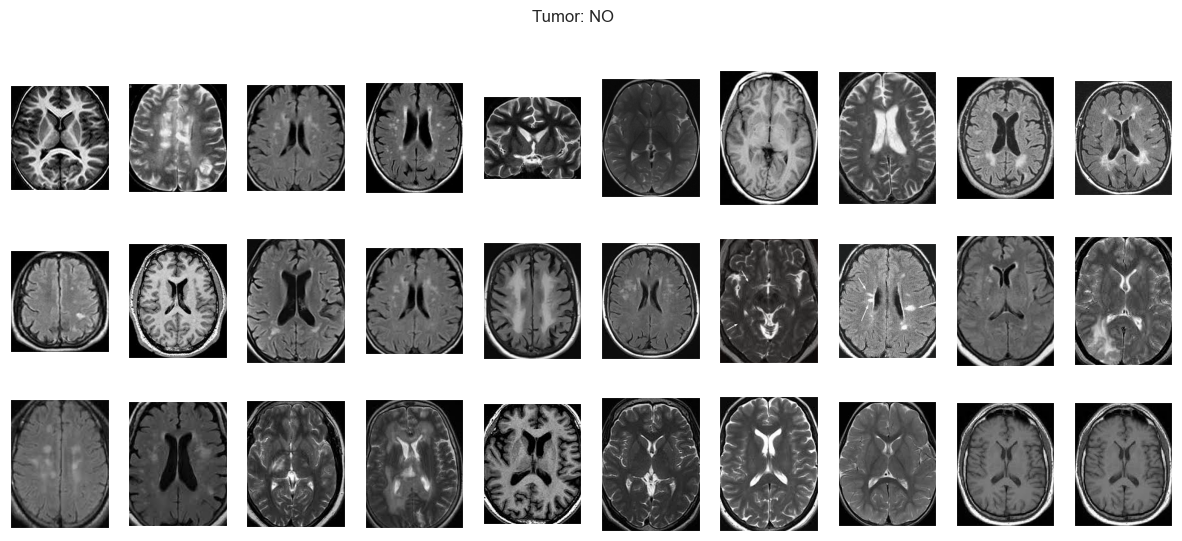

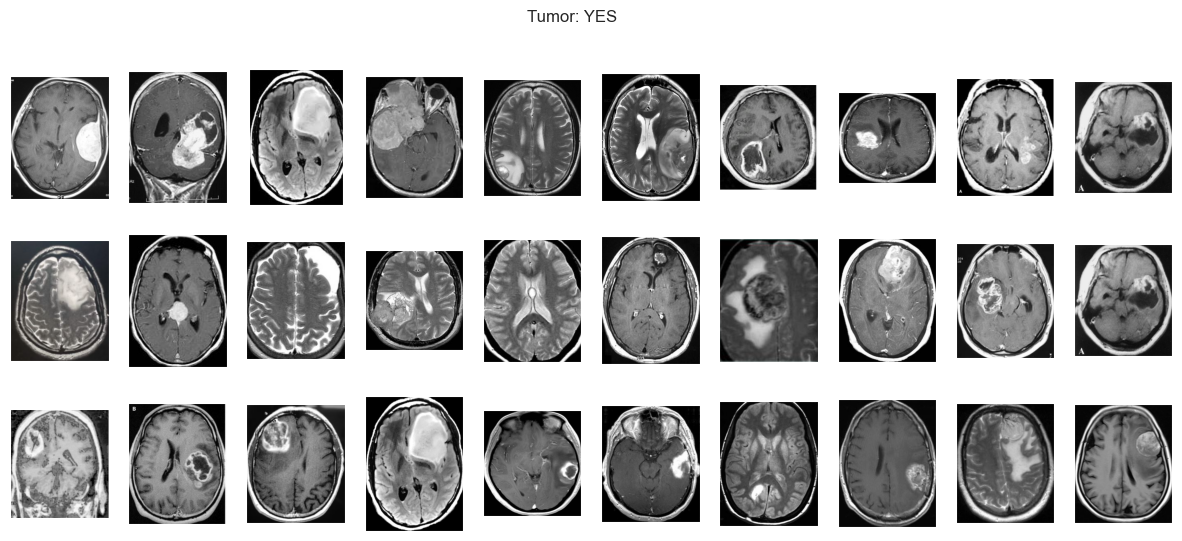

In [14]:
plot_samples(X_train_crop, y_train, labels, 30)

In [15]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [16]:
save_new_images(X_train_crop, y_train, folder_name='CROPPED/TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='CROPPED/VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='CROPPED/TEST_CROP/')

The next step would be resizing images to (224,224) and applying preprocessing needed for VGG-16 model input

In [17]:
def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-16 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [18]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

In [19]:
train_x = np.array(X_train_prep)
test_x = np.array(X_test_prep)
val_x = np.array(X_val_prep)

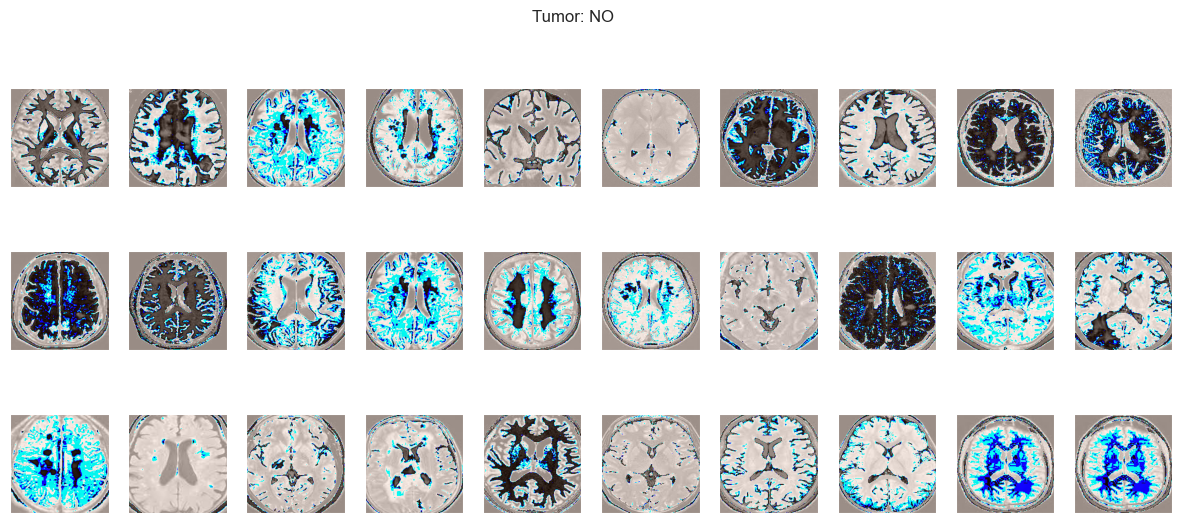

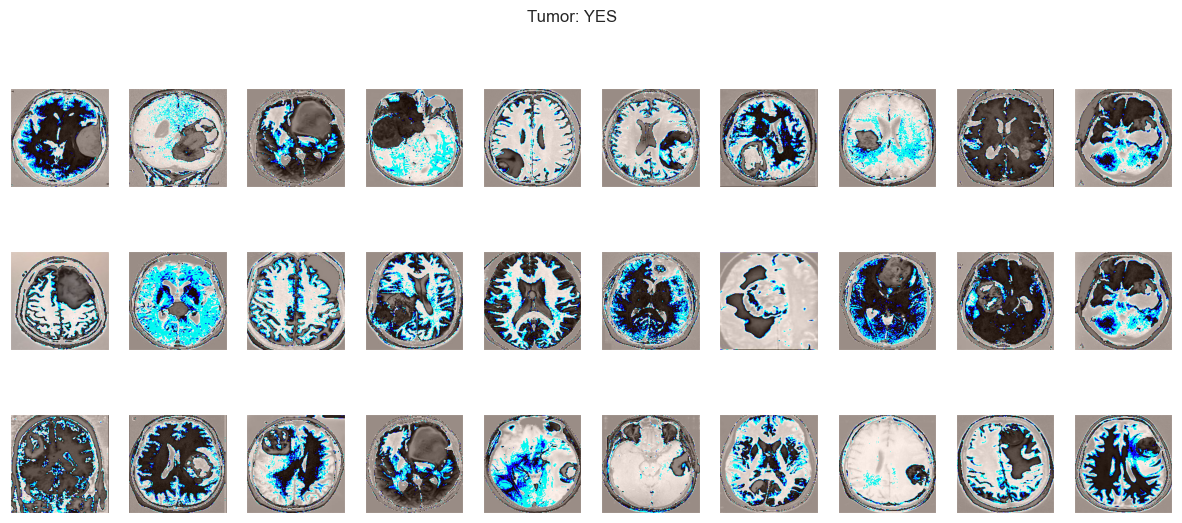

In [20]:
plot_samples(X_train_prep,y_train,labels,30)

# Pre-preocssing the data for CNN

## Data Augmentation

In [21]:
demo_datagen = ImageDataGenerator(
    rotation_range = 15,
    width_shift_range = 0.05,
    height_shift_range = 0.05,
    rescale = 1./255,
    shear_range = 0.05,
    brightness_range = [0.1,1.5],
    horizontal_flip = True,
    vertical_flip = True
)

In [22]:
x = X_train_crop[0]  
x = x.reshape((1,) + x.shape) 

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break 

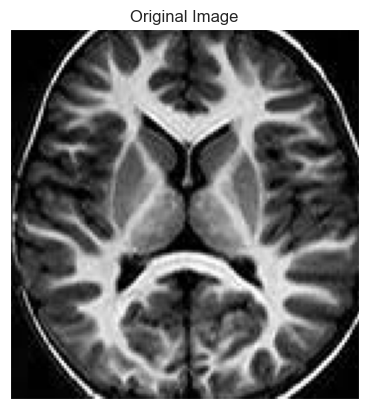

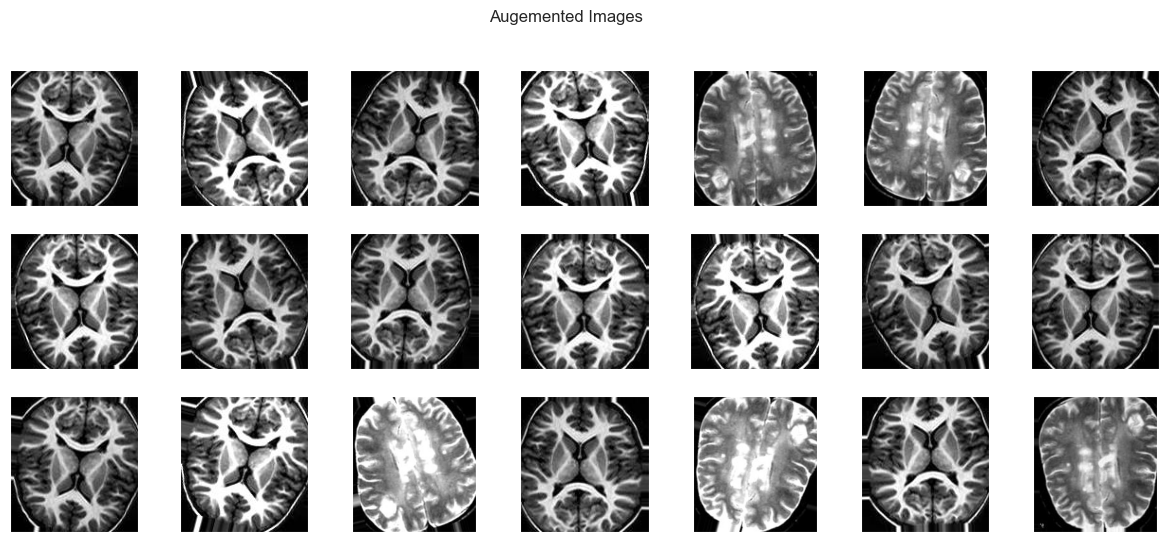

In [23]:
plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title("Original Image")
plt.show()

plt.figure(figsize=(15,6))
i=1
for img in os.listdir('preview/'):
    img = cv2.imread('preview/'+ img)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i>3*7:
        break
plt.suptitle('Augemented Images')
plt.show()
    

In [24]:
IMG_SIZE

(180, 180)

In [25]:
TRAIN_DIR = 'CROPPED/TRAIN_CROP/'
VAL_DIR = 'CROPPED/VAL_CROP/'
TEST_DIR = 'CROPPED/TEST_CROP/'

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    color_mode='rgb',
    target_size = IMG_SIZE,
    class_mode = 'binary'
)

validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 193 images belonging to 2 classes.
Found 10 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [26]:
train_y = train_generator.classes
test_y = test_generator.classes
val_y = validation_generator.classes

In [27]:
base_model = tf.keras.applications.VGG16(weights='imagenet',
                                              include_top=False,
                                              input_shape = IMG_SIZE + (3,)
                                              )

In [28]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

model.layers[0].trainable = False

model.compile(optimizer=Adam(0.001),
              loss='binary_crossentropy',
              metrics=['accuracy']
             )
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                                 
 dropout (Dropout)           (None, 12800)             0         
                                                                 
 dense (Dense)               (None, 1)                 12801     
                                                                 
Total params: 14,727,489
Trainable params: 12,801
Non-trainable params: 14,714,688
_________________________________________________________________


In [29]:
EPOCHS = 50
batch_size = 32

history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    steps_per_epoch=int(193/batch_size), 
    validation_steps=int(50/batch_size)
)

Epoch 1/50
6/6 [==============================] - 13s 2s/step - loss: 4.8424 - accuracy: 0.5839 - val_loss: 2.4906 - val_accuracy: 0.6875
Epoch 2/50
6/6 [==============================] - 12s 2s/step - loss: 4.3774 - accuracy: 0.6708 - val_loss: 1.3092 - val_accuracy: 0.7500
Epoch 3/50
6/6 [==============================] - 13s 2s/step - loss: 4.1923 - accuracy: 0.7019 - val_loss: 1.4388 - val_accuracy: 0.9375
Epoch 4/50
6/6 [==============================] - 13s 2s/step - loss: 3.6978 - accuracy: 0.6894 - val_loss: 0.0429 - val_accuracy: 1.0000
Epoch 5/50
6/6 [==============================] - 13s 2s/step - loss: 2.7315 - accuracy: 0.7516 - val_loss: 0.1987 - val_accuracy: 0.9375
Epoch 6/50
6/6 [==============================] - 13s 2s/step - loss: 2.9146 - accuracy: 0.7950 - val_loss: 1.2273 - val_accuracy: 0.8750
Epoch 7/50
6/6 [==============================] - 13s 2s/step - loss: 2.2220 - accuracy: 0.8075 - val_loss: 0.5307 - val_accuracy: 0.9375
Epoch 8/50
6/6 [==================

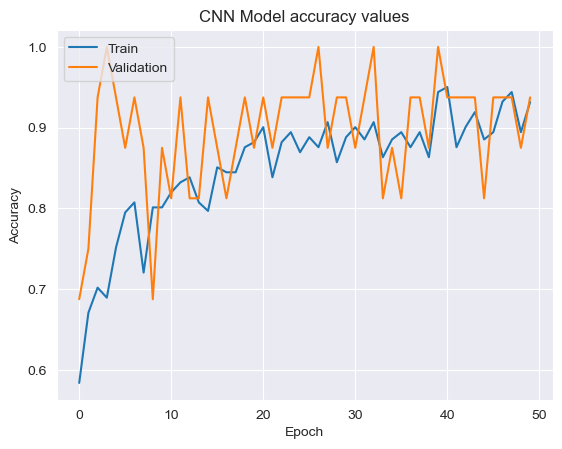

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN Model accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

From this plot, we are able to tell that our model has got less data, thats why it fluctuated a lot during training and validation phase

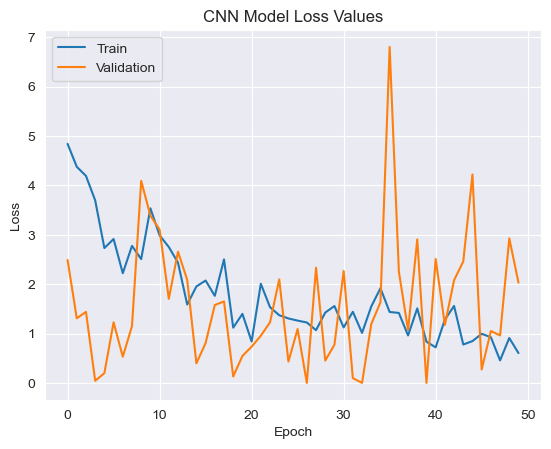

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN Model Loss Values')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [32]:
# Classification Report < 0.90
# Confusion Matrix (Validation Data)
# Accuracy Score
# Cohen Kappa Score
# Hyperparamter tuning
# retraining model
# testing on different images

# Result

In [33]:
model.save('best_models/brain_tumor')

INFO:tensorflow:Assets written to: best_models/brain_tumor\assets


INFO:tensorflow:Assets written to: best_models/brain_tumor\assets


# Load the best model

Experimenting with the Best Model ( The one with the best validation accuracy )

In [34]:
from keras.models import load_model
best_model = load_model(filepath='best_models/brain_tumor')

In [35]:
best_model.metrics_names

['loss', 'accuracy']

In [36]:
loss , accuracy = best_model.evaluate(test_x,test_y)

1/1 [==============================] - 1s 803ms/step - loss: 2.1426 - accuracy: 0.9000


# Accuracy of the best model on the testing data:

In [37]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {accuracy}")

Test Loss = 2.1425888538360596
Test Accuracy = 0.8999999761581421


# F1 score for the best model on the testing data:

In [38]:
y_test_prob = best_model.predict(test_x)

1/1 [==============================] - 1s 701ms/step


In [39]:
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")

F1 score: 0.9


Let's also find the f1 score on the validation data:

In [40]:
y_val_prob = best_model.predict(val_x)

2/2 [==============================] - 3s 1s/step


In [41]:
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")

F1 score: 0.92
